In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load Data

In [4]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [5]:
dataset_path = "./dataset"

In [6]:
dataset = datasets.ImageFolder(root = dataset_path, transform=image_transforms)
len(dataset)

2300

In [7]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [8]:
num_classes = len(dataset.classes)
num_classes

6

In [9]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size
train_size, val_size

(1725, 575)

In [10]:
from torch.utils.data import random_split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

## ModelCNN 

In [12]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2, padding=0),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self,x):
        x = self.network(x)
        return x

In [13]:
# instantiate the model, loss funct, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
def train_model(model, criterion, optimizer, epochs):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            if(batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch:{epoch+1}, Loss:{loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss: .4f}")

        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []


        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            print(f"*** Validation Accuracy: {100*correct/total:.2f}%***")

    end = time.time()
    print(f"Execution time: {end - start} seconds")
    return all_labels, all_predictions 

In [15]:
all_labels, all_predictions = train_model(model, criterion, optimizer,epochs=5)

Batch: 10, Epoch:1, Loss:1.75
Batch: 20, Epoch:1, Loss:1.83
Batch: 30, Epoch:1, Loss:1.74
Batch: 40, Epoch:1, Loss:1.59
Batch: 50, Epoch:1, Loss:1.48
Epoch [1/5], Avg Loss:  1.7613
*** Validation Accuracy: 41.74%***
Batch: 10, Epoch:2, Loss:1.32
Batch: 20, Epoch:2, Loss:1.40
Batch: 30, Epoch:2, Loss:0.91
Batch: 40, Epoch:2, Loss:1.38
Batch: 50, Epoch:2, Loss:1.28
Epoch [2/5], Avg Loss:  1.3054
*** Validation Accuracy: 48.70%***
Batch: 10, Epoch:3, Loss:0.94
Batch: 20, Epoch:3, Loss:1.04
Batch: 30, Epoch:3, Loss:1.29
Batch: 40, Epoch:3, Loss:0.96
Batch: 50, Epoch:3, Loss:1.18
Epoch [3/5], Avg Loss:  1.1263
*** Validation Accuracy: 50.96%***
Batch: 10, Epoch:4, Loss:1.10
Batch: 20, Epoch:4, Loss:1.19
Batch: 30, Epoch:4, Loss:0.72
Batch: 40, Epoch:4, Loss:0.82
Batch: 50, Epoch:4, Loss:1.35
Epoch [4/5], Avg Loss:  1.0314
*** Validation Accuracy: 55.30%***
Batch: 10, Epoch:5, Loss:1.10
Batch: 20, Epoch:5, Loss:1.19
Batch: 30, Epoch:5, Loss:1.38
Batch: 40, Epoch:5, Loss:1.09
Batch: 50, Epoch

## Model 2: CNN with Regularization

In [16]:
class CarClassifierCNNwithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2, padding=0),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self,x):
        x = self.network(x)
        return x

In [17]:
model = CarClassifierCNNwithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001 , weight_decay=1e-4)

In [18]:
all_labels, all_predictions = train_model(model, criterion, optimizer,epochs=10)

Batch: 10, Epoch:1, Loss:13.27
Batch: 20, Epoch:1, Loss:5.08
Batch: 30, Epoch:1, Loss:1.86
Batch: 40, Epoch:1, Loss:1.53
Batch: 50, Epoch:1, Loss:1.67
Epoch [1/10], Avg Loss:  7.0740
*** Validation Accuracy: 32.00%***
Batch: 10, Epoch:2, Loss:1.48
Batch: 20, Epoch:2, Loss:1.52
Batch: 30, Epoch:2, Loss:1.36
Batch: 40, Epoch:2, Loss:1.42
Batch: 50, Epoch:2, Loss:1.82
Epoch [2/10], Avg Loss:  1.6138
*** Validation Accuracy: 34.43%***
Batch: 10, Epoch:3, Loss:1.57
Batch: 20, Epoch:3, Loss:1.29
Batch: 30, Epoch:3, Loss:1.61
Batch: 40, Epoch:3, Loss:1.38
Batch: 50, Epoch:3, Loss:1.73
Epoch [3/10], Avg Loss:  1.5245
*** Validation Accuracy: 40.52%***
Batch: 10, Epoch:4, Loss:1.32
Batch: 20, Epoch:4, Loss:1.30
Batch: 30, Epoch:4, Loss:1.45
Batch: 40, Epoch:4, Loss:1.51
Batch: 50, Epoch:4, Loss:1.52
Epoch [4/10], Avg Loss:  1.4248
*** Validation Accuracy: 45.22%***
Batch: 10, Epoch:5, Loss:1.26
Batch: 20, Epoch:5, Loss:1.63
Batch: 30, Epoch:5, Loss:1.23
Batch: 40, Epoch:5, Loss:1.36
Batch: 50, 

## Model 3: Transfer Learning with EfficientNet

In [19]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [20]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=0.001)

In [21]:
all_labels, all_predictions = train_model(model, criterion, optimizer,epochs=10)

Batch: 10, Epoch:1, Loss:1.65
Batch: 20, Epoch:1, Loss:1.62
Batch: 30, Epoch:1, Loss:1.40
Batch: 40, Epoch:1, Loss:1.32
Batch: 50, Epoch:1, Loss:1.17
Epoch [1/10], Avg Loss:  1.4628
*** Validation Accuracy: 58.43%***
Batch: 10, Epoch:2, Loss:1.12
Batch: 20, Epoch:2, Loss:0.97
Batch: 30, Epoch:2, Loss:1.08
Batch: 40, Epoch:2, Loss:1.22
Batch: 50, Epoch:2, Loss:1.21
Epoch [2/10], Avg Loss:  1.1279
*** Validation Accuracy: 61.39%***
Batch: 10, Epoch:3, Loss:0.99
Batch: 20, Epoch:3, Loss:1.01
Batch: 30, Epoch:3, Loss:0.97
Batch: 40, Epoch:3, Loss:0.89
Batch: 50, Epoch:3, Loss:0.81
Epoch [3/10], Avg Loss:  1.0003
*** Validation Accuracy: 63.13%***
Batch: 10, Epoch:4, Loss:1.16
Batch: 20, Epoch:4, Loss:0.87
Batch: 30, Epoch:4, Loss:0.82
Batch: 40, Epoch:4, Loss:1.03
Batch: 50, Epoch:4, Loss:0.77
Epoch [4/10], Avg Loss:  0.9347
*** Validation Accuracy: 63.30%***
Batch: 10, Epoch:5, Loss:0.87
Batch: 20, Epoch:5, Loss:0.84
Batch: 30, Epoch:5, Loss:1.02
Batch: 40, Epoch:5, Loss:0.74
Batch: 50, E

## Model 4: Transfer Learning with RestEfficientNet 

In [22]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [23]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=0.001)

In [24]:
labels, predictions = train_model(model, criterion, optimizer,epochs=10)

Batch: 10, Epoch:1, Loss:0.92
Batch: 20, Epoch:1, Loss:0.71
Batch: 30, Epoch:1, Loss:0.87
Batch: 40, Epoch:1, Loss:0.85
Batch: 50, Epoch:1, Loss:0.54
Epoch [1/10], Avg Loss:  0.8856
*** Validation Accuracy: 67.83%***
Batch: 10, Epoch:2, Loss:0.54
Batch: 20, Epoch:2, Loss:0.32
Batch: 30, Epoch:2, Loss:0.30
Batch: 40, Epoch:2, Loss:0.36
Batch: 50, Epoch:2, Loss:0.78
Epoch [2/10], Avg Loss:  0.4911
*** Validation Accuracy: 76.87%***
Batch: 10, Epoch:3, Loss:0.45
Batch: 20, Epoch:3, Loss:0.28
Batch: 30, Epoch:3, Loss:0.33
Batch: 40, Epoch:3, Loss:0.35
Batch: 50, Epoch:3, Loss:0.34
Epoch [3/10], Avg Loss:  0.3456
*** Validation Accuracy: 71.83%***
Batch: 10, Epoch:4, Loss:0.32
Batch: 20, Epoch:4, Loss:0.28
Batch: 30, Epoch:4, Loss:0.05
Batch: 40, Epoch:4, Loss:0.39
Batch: 50, Epoch:4, Loss:0.18
Epoch [4/10], Avg Loss:  0.2498
*** Validation Accuracy: 80.87%***
Batch: 10, Epoch:5, Loss:0.20
Batch: 20, Epoch:5, Loss:0.07
Batch: 30, Epoch:5, Loss:0.07
Batch: 40, Epoch:5, Loss:0.11
Batch: 50, E

## Model Evaluation using Confusion Matrix and Classifiaction report

In [25]:
from sklearn.metrics import classification_report
report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       119
           1       0.70      0.80      0.75        95
           2       0.94      0.85      0.89       125
           3       0.92      0.58      0.71        85
           4       0.65      0.86      0.74        85
           5       0.73      0.77      0.75        66

    accuracy                           0.80       575
   macro avg       0.80      0.79      0.78       575
weighted avg       0.82      0.80      0.80       575



In [27]:
class_names = dataset.classes

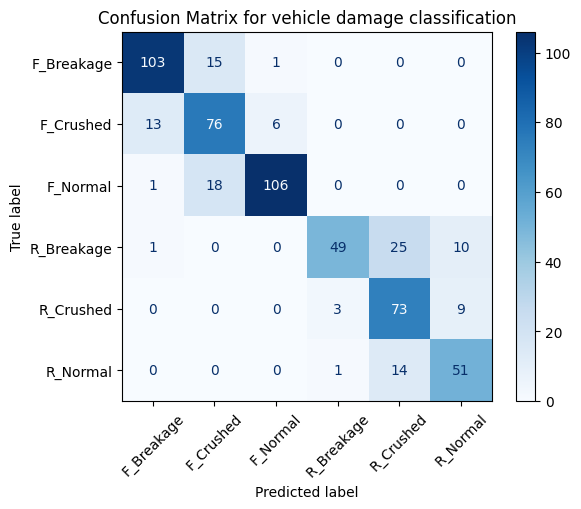

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for vehicle damage classification")
plt.show()

In [29]:
torch.save(model.state_dict(),'saved_model.pth')